In [2]:
import pandas as pd
import os
import random
from tqdm import tqdm
import pickle

In [3]:
PATH_TO_LOAD = '../data/04_Merged'

merge_context_data = False
regenerate_context_data = True
sequence_augmentation = False

In [4]:
df = pd.read_csv(os.path.join(PATH_TO_LOAD, 'SEB880' + "_merged.csv"), parse_dates=['datetime'], low_memory=False)
df

,index,avg_irradiation,steering_speed,temperature_out,hour,month,odometer,light_sensor_rear,light_sensor_front,temperature_in,...,session,Label,ID,FunctionValue,domain,BeginTime,time_second,distance_driven,ts_normalized,weekday
0,10898,0.000000,0.000000,0.0,20,9,0.0,0.000000,0.000000,0.0,...,7.0,NaN,NaN,NaN,NaN,2022-09-07 20:08:33,0.0,0.0,0.000,2
1,10899,0.000000,0.000000,0.0,20,9,10845.0,0.000000,0.000000,0.0,...,7.0,NaN,NaN,NaN,NaN,2022-09-07 20:08:33,1.0,10845.0,0.000,2
2,10900,0.000000,0.000000,25.0,20,9,10845.0,0.000000,0.000000,0.0,...,7.0,NaN,NaN,NaN,NaN,2022-09-07 20:08:33,2.0,10845.0,0.000,2
3,10901,0.000000,0.000000,25.0,20,9,10845.0,0.000000,0.000000,27.0,...,7.0,NaN,NaN,NaN,NaN,2022-09-07 20:08:33,3.0,10845.0,0.000,2
4,10902,0.000000,0.000000,25.0,20,9,10845.0,0.000000,0.000000,27.0,...,7.0,NaN,NaN,NaN,NaN,2022-09-07 20:08:33,3.0,10845.0,0.000,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1797064,3171685,36.943166,0.000000,21.5,12,7,29982.0,11023.533942,3264.883100,27.5,...,941.0,clima/AC/off,/climate/airConditioning,off,clima,2023-07-06 12:02:40,3003.0,29982.0,0.826,3
1797065,3171687,0.000000,0.000000,27.0,14,7,30120.0,0.000000,0.000000,26.5,...,947.0,media/selectedSource/Radio,/media/context,Radio,media,2023-07-07 11:21:23,9887.0,30120.0,0.948,4
1797066,3171690,24.328657,307.641463,31.5,17,7,30179.0,8800.000000,4866.661787,33.5,...,954.0,media/selectedSource/Radio,/media/context,Radio,media,2023-07-08 17:49:55,167.0,30179.0,0.215,5
1797067,3171691,76.793509,0.000000,35.0,17,7,30256.0,27820.852630,6126.000000,32.0,...,956.0,media/selectedSource/Radio,/media/context,Radio,media,2023-07-09 16:56:35,1324.0,30256.0,0.173,6


In [5]:
df.columns

Index(['index', 'avg_irradiation', 'steering_speed', 'temperature_out', 'hour',
       'month', 'odometer', 'light_sensor_rear', 'light_sensor_front',
       'temperature_in', 'KBI_speed', 'soc', 'ESP_speed', 'latitude',
       'longitude', 'seatbelt_codriver', 'seatbelt_rear_l', 'seatbelt_rear_m',
       'seatbelt_rear_r', 'CHA_ESP_drive_mode', 'CHA_MO_drive_mode',
       'rain_sensor', 'street_category', 'kickdown', 'altitude',
       'driving_program', 'datetime', 'session', 'Label', 'ID',
       'FunctionValue', 'domain', 'BeginTime', 'time_second',
       'distance_driven', 'ts_normalized', 'weekday'],
      dtype='object')

In [38]:
toexclude = ['CHA_ESP_drive_mode', 
             'CHA_MO_drive_mode',
             'rain_sensor',
             'kickdown',
             'ESP_speed',
             'seatbelt_rear_m',
            'driving_program',
            
             ]

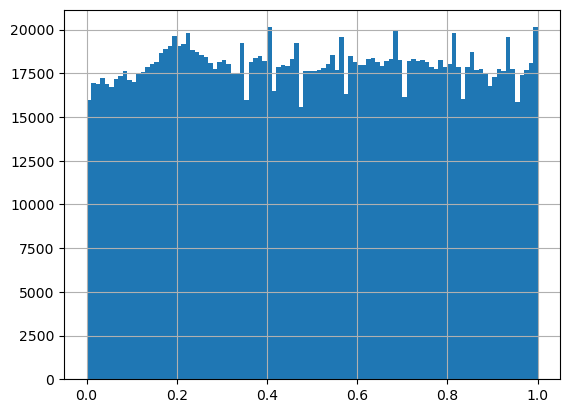

In [39]:
hist = df['ts_normalized'].hist(bins=100)

In [3]:
dynamic_context_var = ['KBI_speed']
static_context_var = ['car_id']

In [4]:
## create context data

def load_context(vehicle):
    df = pd.read_csv(os.path.join(PATH_TO_LOAD, vehicle + "_merged.csv"), parse_dates=['datetime'], low_memory=False)
    df_filt = df[['session','datetime', 'KBI_speed']]
    df_filt = df_filt.dropna(subset=['KBI_speed'])
    df_filt_sort = df_filt.sort_values(by=['session','datetime'])
    return df_filt_sort

vehicles = ['SEB880','SEB882','SEB883','SEB885','SEB888','SEB889']
context_data = pd.DataFrame()

if merge_context_data == True:
    for vehicle in tqdm(vehicles):
        context_curr = load_context(vehicle)
        context_curr['car_id'] = vehicle
        context_data = pd.concat([context_data, context_curr], axis=0)
    context_data.to_csv('../data/05_Interaction_Sequences/context.csv')

if regenerate_context_data == True:
    # selected_sessions = merged_df['session'].unique().tolist()

    context_data = pd.read_csv('../data/05_Interaction_Sequences/context.csv', parse_dates=['datetime'], index_col=0)
    
    vehicle_list = context_data.car_id.unique().tolist()
    vehicle_dict = {vehicle: random.randint(1, 50) for vehicle in vehicle_list}
    context_data['car_id'] = context_data['car_id'].map(vehicle_dict)
    context_data = context_data.sort_values(by=['session','datetime'])
    context_data['session'] = context_data['session'].astype(int)
    static_context_var.append('session')
    static_context = context_data[static_context_var].drop_duplicates(subset=['car_id', 'session'])
    # context_data = context_data[dynamic_context]
    # selected_context = ['KBI_speed', 'car_id']
    dynamic_context_var.extend(['session', 'datetime'])
    dynamic_context = context_data[dynamic_context_var]
    dynamic_context_var = [item for item in dynamic_context_var if item not in ['session', 'datetime']]
    dynamic_context = dynamic_context.groupby(['session', 'datetime'])[dynamic_context_var].mean().reset_index()

In [5]:
selected_sequence = pd.read_csv('../data/05_Interaction_Sequences/sequence_context.csv', parse_dates=['datetime'], index_col=0).reset_index()
selected_sequence['session'] = selected_sequence['session'].astype(int)

temp_df = selected_sequence.groupby('session').apply(lambda group: group.iloc[:-1]).reset_index(drop=True)
dynamic_context = dynamic_context[dynamic_context['session'].isin(temp_df.session.unique().tolist())]

training_sequence_context = pd.DataFrame()
for session in tqdm(selected_sequence['session'].unique().tolist()):
    selected_sequence_curr = selected_sequence[selected_sequence['session']==session]
    context_data_curr = dynamic_context[dynamic_context['session']==session]
    context_data_curr = context_data_curr[context_data_curr['datetime']<=selected_sequence_curr['datetime'].max()]
    training_sequence_context = pd.concat([training_sequence_context,context_data_curr], axis=0)


100%|██████████| 954/954 [00:49<00:00, 19.43it/s]


In [29]:
# testing_sessions = [16, 25]
# selected_sequence = selected_sequence[selected_sequence['session'].isin(testing_sessions)]
# training_sequence_context = training_sequence_context[training_sequence_context['session'].isin(testing_sessions)]

training_sequence_context_augmented = pd.DataFrame()
session_id = 0
if sequence_augmentation == True:
    for session in tqdm(selected_sequence['session'].unique().tolist()):
        selected_sequence_curr = selected_sequence[selected_sequence['session']==session].reset_index()
        context_curr = training_sequence_context[training_sequence_context['session']==session].reset_index()
        for i in range(len(selected_sequence_curr)-1, -1, -1):
            context_filt_curr = training_sequence_context[
                (training_sequence_context['datetime'] <= selected_sequence_curr.loc[i, 'datetime'])].copy()
            # context_filt_curr.loc[context_filt_curr.index, 'session_id'] = session_id
            context_filt_curr['session_id'] = session_id
            training_sequence_context_augmented = pd.concat([training_sequence_context_augmented, context_filt_curr], axis=0)
            session_id += 1
    dynamic_context = training_sequence_context_augmented
else:
    # if sequence_augmentation is set to false
    dynamic_context = training_sequence_context


with open('../data/05_Interaction_Sequences/train_sessions.pkl', 'rb') as pickle_file:
    train_sessions = pickle.load(pickle_file)

with open('../data/05_Interaction_Sequences/test_sessions.pkl', 'rb') as pickle_file:
    test_sessions = pickle.load(pickle_file)

train_context_data = dynamic_context[dynamic_context['session'].isin(train_sessions)]
test_context_data = dynamic_context[dynamic_context['session'].isin(test_sessions)]

train_static_context = static_context[static_context['session'].isin(train_sessions)]
test_static_context = static_context[static_context['session'].isin(test_sessions)]

train_static_context['session'] = range(len(train_static_context))
test_static_context['session'] = range(len(test_static_context))

train_context_data['session'] = train_context_data.groupby('session').ngroup()
test_context_data['session'] = test_context_data.groupby('session').ngroup()

train_context_data = train_context_data.rename(columns={'session': 'session_id'})
test_context_data = test_context_data.rename(columns={'session': 'session_id',})

train_context_data.to_csv('../datasets/sequential/carsii_timedelta_rand_seq/dynamic_context/train.csv', index=False)
test_context_data.to_csv('../datasets/sequential/carsii_timedelta_rand_seq/dynamic_context/test.csv', index=False)

train_static_context.to_csv('../datasets/sequential/carsii_timedelta_rand_seq/static_context/train.csv', index=False)
test_static_context.to_csv('../datasets/sequential/carsii_timedelta_rand_seq/static_context/test.csv', index=False)

/var/folders/n8/1ntcg5gj7nvf5wh_s2w95yh80000gn/T/ipykernel_5448/726347031.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_static_context['session'] = range(len(train_static_context))
/var/folders/n8/1ntcg5gj7nvf5wh_s2w95yh80000gn/T/ipykernel_5448/726347031.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_static_context['session'] = range(len(test_static_context))
/var/folders/n8/1ntcg5gj7nvf5wh_s2w95yh80000gn/T/ipykernel_5448/726347031.py:39: SettingWithCopyWarning: 
A value is trying to